In [46]:
!pip install -U transformers datasets peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 14.2 MB/s eta 0:00:00


In [47]:
import json

captions = [{"file_name": "hip.jpeg", "text": "An X-Ray showing healthy hips"},
{"file_name": "kneecap.jpeg", "text": "An X-ray showing healthy knee cap"},
{"file_name": "lungs.jpeg", "text": "An X-ray showing healthy lungs"},
{"file_name": "ribcage.jpeg", "text": "An X-Ray showing healthy ribcage"},
{"file_name": "shoulder.jpeg", "text": "An X-Ray showing broken shoulder"},
{"file_name": "spine.jpeg", "text": "An X-Ray showing bent spine "},
{"file_name": "teeth.jpeg", "text": "An X-Ray showing painfull teeth "}]

# path to the folder containing the images
root = "/content/X-ray/"

# add metadata.jsonl file to this folder
with open(root + "metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item) + "\n")


In [48]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir=root, split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [49]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 7
})

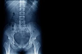

In [50]:
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))


In [51]:
example["text"]


'An X-Ray showing healthy hips'

In [52]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from transformers import ViTFeatureExtractor, VisionEncoderDecoderModel, AutoProcessor


from datasets import load_dataset
from peft import LoraConfig, get_peft_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [53]:
loc = "nlpconnect/vit-gpt2-image-captioning"

feature_extractor = ViTFeatureExtractor.from_pretrained(loc)
model = VisionEncoderDecoderModel.from_pretrained(loc)
processor = AutoProcessor.from_pretrained(loc)

model = model.to(device)

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [54]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor, feature_extractor):
        self.dataset = dataset
        self.processor = processor
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.feature_extractor(images=item["image"], return_tensors="pt")
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

train_dataset = ImageCaptioningDataset(dataset, processor, feature_extractor)

In [55]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["query","value"],
)

model = get_peft_model(model, config)

In [56]:
def collator(batch):
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor([example["text"] for example in batch], padding=True, return_tensors="pt")
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]

    return processed_batch

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collator)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 100

In [57]:
loss_list = []
model.train()
for epoch in range(1, epochs+1):
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device, torch.float16)

        outputs = model(pixel_values=pixel_values, labels=input_ids)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if epoch % 10 == 0: print(f"Epoch {epoch} done!, Loss: {loss.item()}")
    loss_list.append(loss.item())

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


In [ ]:
model.save_pretrained("/content/saved_model")
processor.save_pretrained("/content/saved_model")
feature_extractor.save_pretrained("/content/saved_model")


In [ ]:
from peft import LoraConfig, PeftModel


feature_extractor = ViTFeatureExtractor.from_pretrained(loc)
model = VisionEncoderDecoderModel.from_pretrained(loc)
processor = AutoProcessor.from_pretrained(loc)
adapter_path="/content/saved_model"
model_1 = PeftModel.from_pretrained(model, adapter_path)
model_1 = model_1.to(device)



# Function for inference
def generate_caption(image_path):
    # Load and preprocess the image
    image = Image.open(image_path)

    # Extract features
    pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

    # Generate caption
    with torch.no_grad():
        outputs = model_1.generate(pixel_values=pixel_values)

    # Decode the generated caption
    caption = processor.decode(outputs[0], skip_special_tokens=True)
    return caption

# Example usage
image_path = "/content/download.jpeg"  # Replace with your image path
caption = generate_caption(image_path)
print("Generated Caption:", caption)